In [1]:
'''This salary prediction model pulls job data and predicts salaries across multiple models. 
    It then saves the model and produces a prediction file.'''

'This salary prediction model pulls job data and predicts salaries across multiple models. \n    It then saves the model and produces a prediction file.'

In [2]:
__author__ = "Khalid Rahman"
__email__ = "kirahman2@gmail.com"

### Import packages

In [260]:
#!/usr/bin/env python3
#import your libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.externals import joblib
import pickle
import os

### Defining Data class

In [141]:
class Data:
    def __init__(self, train_file, train_target_file, test_file, col_cat, col_num, col_id, col_target):
        '''create train and test dataframes'''
        self.col_cat = col_cat
        self.col_num = col_num
        self.col_all = col_cat + col_num
        self.col_id = col_id
        self.col_target = col_target
        self.train_eda = pd.DataFrame()
        self.train_raw = pd.DataFrame()
        self.test_raw = pd.DataFrame()
        self.train_df = self._create_train_df(train_file, train_target_file)
        self.test_df = self._create_test_df(test_file)
        
    def _create_train_df(self, train_df, train_target):
        '''create train dataframe'''
        target = self._load_file(train_target)
        df = self._load_file(train_df)
        df = self._join_df(df, target, self.col_id)
        df = self._correct_data(df)
        self.train_eda = df
        df = self._clean_data(df)
        df = self._shuffle_data(df)
        self.train_raw = df
        df = self._label_encode(df, self.col_cat)
        return df
    
    def _create_test_df(self, test_file):
        '''create test dataframe'''
        df = self._load_file(test_file)
        df = self._correct_data(df)
        self.test_raw = df
        df = self._label_encode(df, self.col_cat)
        return df

    def _shuffle_data(self, df):
        '''shuffling data'''
        return shuffle(df, random_state=42).reset_index(drop=True)

    def _clean_data(self, df):
        '''remove outliers from data'''
        return df[(df.salary>8) & (df.salary<220)]
    
    def _correct_data(self,df):
        '''correcting data values'''
        list_index = df[ (df['degree']!='HIGH_SCHOOL')
                       & (df['degree']!='NONE') 
                       & (df['major']=='NONE')
                       ].index
        df.loc[list_index,'major'] = 'MISSING'
        return df
    
    def _label_encode(self, df, col_cat):
        '''label encode dataframes'''
        le = LabelEncoder()
        for col in col_cat:
            df[col] = le.fit_transform(df[col])
        return df
         
    def _join_df(self, train_df, train_target, col_id):
        '''join train and target dataframes'''
        return pd.merge(train_df, train_target, on=col_id, how='inner')

    def _load_file(self, file):
        '''load files'''
        return pd.read_csv(file)

### Defining Feature Engineering class

In [8]:
class FeatureEngineering:
    def __init__(self, train_raw, train_df, test_raw, test_df, col_cat, target, col_id):
        '''create train and test dataframes'''
        df_temp = pd.DataFrame()
        self.train_df = train_df
        self.train_raw = train_raw
        self.test_df = test_df
        self.test_raw = test_raw
        self._groupby(self.train_raw, train_df, self.test_raw, col_cat, target)
    
    def _groupby(self, train_raw, train_df, test_raw, col_cat, col_target):
        '''parse through each categorical column and compute mean of each unique value'''
        for i in range(0, len(col_cat)):
            df_temp = self._compute_mean(train_raw, col_cat, i, col_target)
            list_col_temp = df_temp[col_cat[i]]
            list_col_target = df_temp[col_target]
            dict_temp = self._create_dictionary(df_temp, list_col_temp, list_col_target)
            data.train_df[col_cat[i] +'_mean'] = self._map_dictionary(train_raw, col_cat, i, dict_temp)
            data.test_df[col_cat[i] +'_mean'] = self._map_dictionary(test_raw, col_cat, i, dict_temp)
            self._append_columns(train_df, col_cat, i)
        data.col_all = data.col_cat + data.col_num
    
    def _compute_mean(self, train_raw, col_cat, i, col_target):
        '''compute mean of unique categorical values'''
        return train_raw.groupby(col_cat[i])[col_target].mean().sort_values(ascending=True).reset_index()
        
    def _create_dictionary(self, df_temp, list_col_temp, list_col_target):
        '''create dictionary of unique categorical values and mean salary values'''
        dict_temp = {}
        for j in range(0,len(df_temp)):
            dict_temp.update([(list_col_temp[j], list_col_target[j])]) 
        return dict_temp
    
    def _map_dictionary(self, df_eda, col_cat, i, dict_temp):
        '''mapping dictionary values'''
        return df_eda[col_cat[i]].map(dict_temp)
    
    def _append_columns(self, train_df, col_cat, i):
        '''appending new column names to col_num list'''
        data.col_num.append(train_df[col_cat[i] +'_mean'].name)

### Defining Model class

In [318]:
class Model:
    def __init__(self, train_features, train_target, model_container, set_cv, num_proc, dir_pred):
        '''create train dataframe'''
        self.train_df = train_features
        self.target = train_target
        self.filename = 'best_model.sav'
    
    def add_model(self, model):
        '''add new model'''
        model_container[model] = self._score_model(model, self.train_df, 
                                                   self.target, set_cv, num_proc)
        pass_temp = model_container[model]
        self._model_summary(model, pass_temp)
    
    def _model_summary(self, model, pass_temp):
        print(model)
        print('score:', model_container[model],'\n')        
        
    def fit_model(self, model, train_df, target):
        '''fit model'''
        return model.fit(train_df, target)
        
    def predict_model(self, model_selected, test_df, train_df, target, save_best_model):
        '''predict and store best model'''
        model = self.fit_model(model_selected, train_df, target)
        self._save_model(model, self.filename, save_best_model)
        prediction_results = model.predict(test_df)
        self._save_prediction(prediction_results)
        return prediction_results

    def _important_features(self, model):
        '''create feature importance dataframe'''
        if hasattr(model,'feature_importances_'):
            col_feat_rank = pd.DataFrame(model.feature_importances_, columns=['score'])
            col_feat = pd.DataFrame(data.col_all, columns=['feature'])
            df_feat = pd.concat([col_feat,col_feat_rank],axis=1).sort_values('score',ascending=False).reset_index(drop=True)
            print('\n', model)
            print("\nFeature Importances\n", df_feat)
            self._feature_barplot(df_feat)
        else:
            return print("\nModel does not have feature_importances_ attribute.")

    def _feature_barplot(self, df):
        '''create feature importance barplot'''
        sns.barplot(df.score,df.feature, palette='Blues_d').set_title('Feature Importances')
        
    def best_scoring_model(self, model_container):
        '''select best scoring model'''
        best_model = min(model_container, key=model_container.get)
        best_score = model_container.get(best_model)
        self._best_model_summary(best_model, best_score)
        return best_model
    
    # NEXT, for feature importance, we need to store each model with fitted results in a file, 
    # then pull the best model and its results
    
    def _best_model_summary(self, best_model, best_score):
        '''print summary results of best model'''
        print('The best model is:\n', best_model)
        print('\nThe best score is:\n', best_score)
        
    def load_model(self, load_best_model, test_df):
        '''load best model and call feature importance'''
        if load_best_model:
            # figure out how to 
            print('\nLoading best saved model...')
            loading_best_model = joblib.load(self.filename)
            self._important_features(loading_best_model)
            model_pred = loading_best_model.predict(test_df)
        else:
            print('\nNo prediction file was created because load_best_model is set to false.')

    def _save_model(self, model, filename, save_best_model):
        '''save best model'''
        if save_best_model:
            pickle.dump(model, open(filename, 'wb'))
            print('The model has been saved.')
        else:
            print('\nThe best model was not saved because save_best_model is set to false.')
        
    def _score_model(self, model, train_df, target_train, set_cv, num_proc):
        '''score model'''
        return -1.0*np.mean(cross_val_score(model, train_df, target_train, scoring='neg_mean_squared_error', cv=set_cv, n_jobs=num_proc))

    def _save_prediction(self, prediction_results):
        '''save predictions as csv file'''
        prediction_results = pd.DataFrame(prediction_results).to_csv(dir_pred)

### Defining parameters to run model

In [319]:
train_file = '/Users/krahman/work/salarypredictionportfolio_old/data/train_features.csv'
test_file = '/Users/krahman/work/salarypredictionportfolio_old/data/test_features.csv'
train_target_file = '/Users/krahman/work/salarypredictionportfolio_old/data/train_salaries.csv'
col_cat = ['companyId', 'jobType', 'degree', 'major', 'industry']
col_num = ['milesFromMetropolis', 'yearsExperience']
col_all = col_cat + col_num
col_id = 'jobId'
col_target = 'salary'

set_cv = 2
num_proc = -1
save_best_model = False
load_best_model = True
dir_pred = '/Users/krahman/work/salarypredictionportfolio/predictions/test_salaries.csv'
model_container = {}

### Create data object

In [320]:
data = Data(train_file, train_target_file, test_file, col_cat, col_num, col_id, col_target)

### Create feature engineering object

In [321]:
fe = FeatureEngineering(data.train_raw, data.train_df, data.test_raw, 
                        data.test_df, data.col_cat, data.col_target, col_id)

### Finalize training, target and test dataframes for our model

In [322]:
train_features = data.train_df[data.col_all]
train_target = data.train_df[col_target]
test_features = data.test_df[data.col_all]

### Create model object

In [323]:
model = Model(train_features, train_target, model_container, set_cv, num_proc, dir_pred)

### Add model, score, select best model, create prediction file and print summary

In [326]:
model.add_model(GradientBoostingRegressor(loss='ls', n_estimators=500, max_depth=5))
model.add_model(ElasticNet())
model.add_model(LinearRegression())

selected_model = model.best_scoring_model(model_container)
pred_result = model.predict_model(selected_model, test_features,
                                  train_features, train_target, save_best_model)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
score: 497.48445089302504 

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
score: 402.9666997471561 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=F

### Load best model and create prediction


Loading best saved model...

 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Feature Importances
                 feature     score
0          jobType_mean  0.403004
1       yearsExperience  0.181435
2   milesFromMetropolis  0.125192
3         industry_mean  0.116661
4           degree_mean  0.070938
5            major_mean  0.062944
6               jobType  0.033245
7              industry  0.002

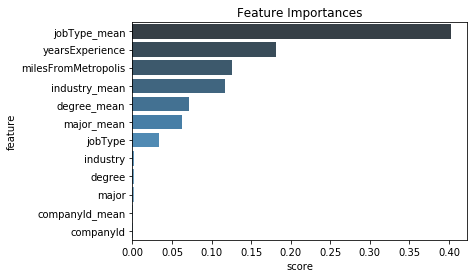

In [325]:
model.load_model(load_best_model, test_features)

### EDA

In [ ]:
# delete once finished
train_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_features.csv')
train_target_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_salaries.csv')
test_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/test_features.csv')

In [ ]:
class Heatmap:
    def __init__(self, train_df, target_df, title):
        '''merge training and target df'''
        self.df = self._merge_df(train_df, target_df)
        self.col = self.df.columns
        self.target = col_target
        self.heatmap = self._create_corr_df(self.df, self.col, self.target, title)

    def _merge_df(self, df, target):
        '''merging training and target dataframes''' 
        return pd.merge(left=target, right=df, on=col_id, how='inner')

    def _create_corr_df(self, df, col, target, title):
        '''creates correlation matrix from train_df'''
        corr = df[self.col].corr()
        self._create_heatmap(corr)
        self._set_title(title)
        
    def _create_heatmap(self, corr):
        '''creates heatmap from correlation matrix'''
        plt.figure(figsize=(4,3))
        return sns.heatmap(corr, xticklabels=corr.columns.values, 
                           yticklabels=corr.columns.values, cmap='Blues', annot=True)
        
    def _set_title(self, title):
        '''sets title of correlation matrix'''
        plt.title(title)

In [131]:
class Boxplot:
    def __init__(self, train_eda, target):
        '''create train and target dataframes'''
        self.df = train_eda
        self.target = target
        
    def create_boxplot(self, val, title):
        '''create boxplot'''
        self._create_subplot()
        self._set_title(title)
        col_avgs = self._calc_averages(self.df, self.target, val)
        sns.boxplot(val, self.target, data=self.df, width=.3, color='#eeefff', order=col_avgs)
        
    def create_dual_boxplot(self, col1, val1, val2, col2, title):
        '''create dual axis boxplot'''
        self._create_subplot()
        self._set_title(title)
        col_avgs = self._calc_averages(self.df, self.target, col2)
        df = self._create_dataframe(self.df, self.target, col1, val1, val2, col2)
        sns.boxplot(x=col2, y=self.target, hue=col1, data=df, palette='Set3', order=col_avgs)
    
    def _create_dataframe(self, df, target, col1, val1, val2, col3):
        '''create dataframe for dual boxplot'''
        return df[(df[col1]==val1) | (df[col1]==val2)].sort_values(self.target, ascending=True)
    
    def _calc_averages(self, df, target, val):
        '''calculate mean values'''
        df = self.df[[val, target]].groupby(val).mean().sort_values(target, ascending=True).reset_index()
        return df[val].values
    
    def _create_subplot(self):
        '''create subplot'''
        plt.subplots(figsize=(12,6.5))
        
    def _set_title(self, title):
        '''create title'''
        plt.title(title)

### Instantiate Boxplot and Heatmap objects

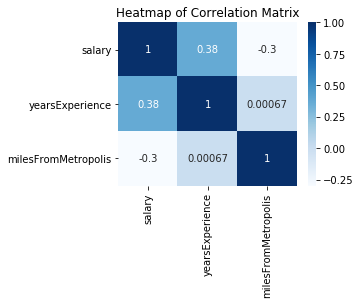

In [133]:
bp = Boxplot(data.train_eda, col_target)
Heatmap(train_features_df, train_target_df, 'Heatmap of Correlation Matrix');

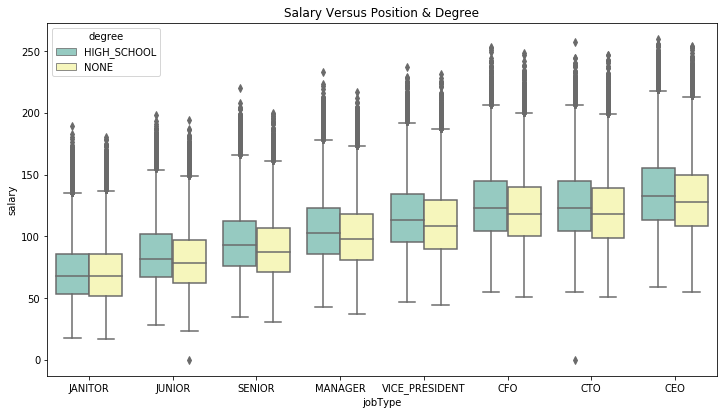

In [16]:
bp.create_dual_boxplot('degree', 'HIGH_SCHOOL', 'NONE', 'jobType', 'Salary Versus Position & Degree')

In [17]:
train_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_features.csv')
train_target_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/train_salaries.csv')
test_features_df = pd.read_csv('/Users/krahman/work/salarypredictionportfolio/data/test_features.csv')

In [18]:
train_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [19]:
train_target_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [20]:
test_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [21]:
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [22]:
train_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [23]:
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [24]:
train_features_sum = train_features_df.duplicated().sum()
train_target_sum = train_target_df.duplicated().sum()
test_features_sum = test_features_df.duplicated().sum()
columns = train_features_df.columns
print('Train features duplicates: {}\nTrain target duplicates: {} \nTest features duplicates: {}\n'.format(train_features_sum, train_target_sum, test_features_sum))
print('Train feature columns:\n', list(columns))

Train features duplicates: 0
Train target duplicates: 0 
Test features duplicates: 0

Train feature columns:
 ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']


In [25]:
col_num = ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']
col_cat = ['yearsExperience', 'milesFromMetropolis']
col_id = 'jobId'

In [26]:
train_features_df.describe(include = np.number)

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [27]:
train_features_df.describe(include = np.object)

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684802051,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


In [28]:
train_df = pd.merge(train_features_df, train_target_df, on=col_id)
train_target = train_target_df

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [30]:
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


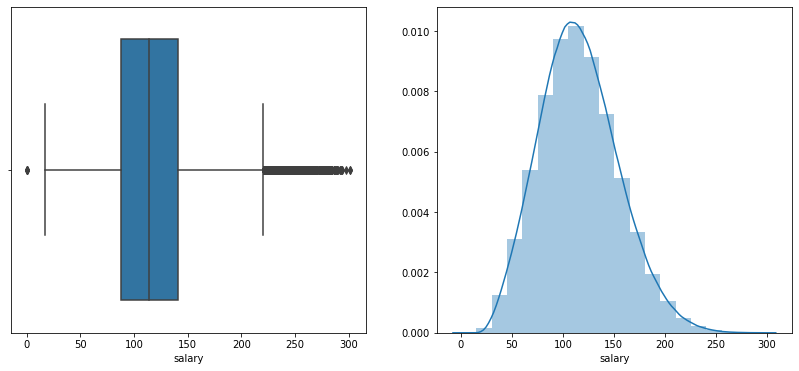

The upper and lower bounds for potential outliers are 220.5 and 8.5.


In [31]:
class TargetVisualization:
    def __init__(self, train_eda, target):
        '''create train and target dataframe'''
        self.df = train_eda
        self.target = target
        self._create_plots()
        self._calculate_iqr()
        
    def _create_plots(self):
        '''create boxplot and distplot'''
        plt.figure(figsize=(14,6))
        plt.subplot(1,2,1)
        sns.boxplot(self.df[self.target])
        plt.subplot(1,2,2)
        sns.distplot(self.df[self.target], bins=20)
        plt.show()
        
    def _calculate_iqr(self):
        '''calculate iqr'''
        stat = self.df[self.target].describe()
        IQR = stat['75%'] - stat['25%']
        upper = stat['75%'] + 1.5 * IQR
        lower = stat['25%'] - 1.5 * IQR
        print('The upper and lower bounds for potential outliers are {} and {}.'.format(upper,lower))

tv = TargetVisualization(data.train_eda, data.col_target)

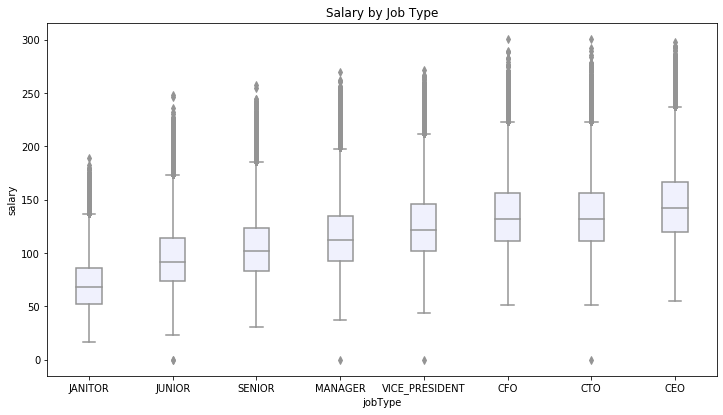

In [33]:
bp.create_boxplot('jobType', 'Salary by Job Type')

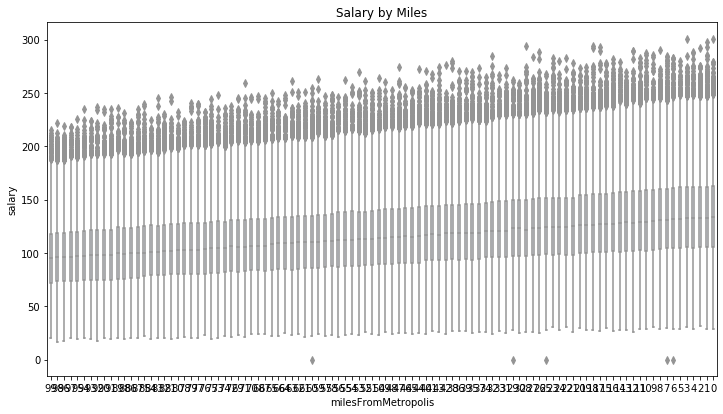

In [34]:
bp.create_boxplot('milesFromMetropolis', 'Salary by Miles')

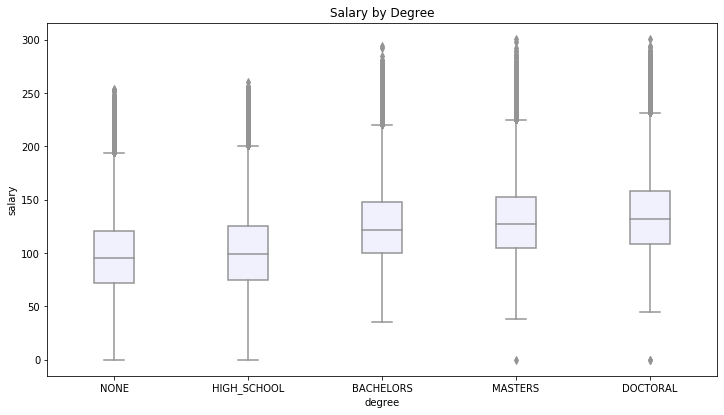

In [35]:
bp.create_boxplot('degree', 'Salary by Degree')

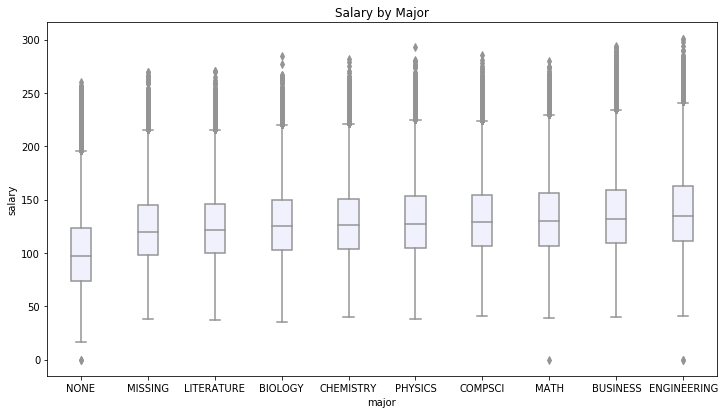

In [36]:
bp.create_boxplot('major', 'Salary by Major')

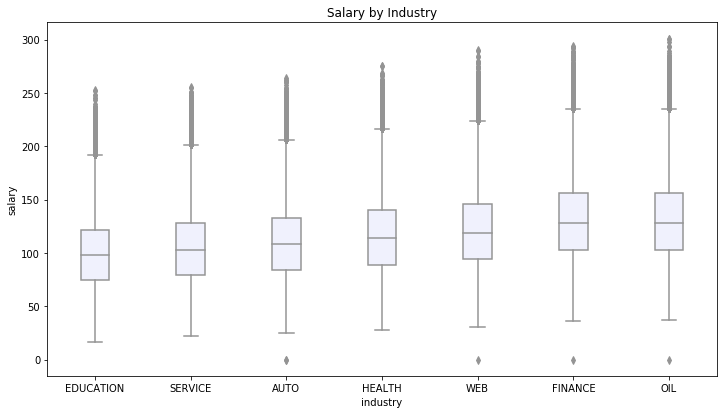

In [37]:
bp.create_boxplot('industry', 'Salary by Industry')

### ---- 11 Automate pipeline ----

In [38]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset